# **Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **GPU**

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=4000 --NotebookApp.port_retries=0

In [2]:
!nvidia-smi

Sat Aug  3 14:48:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **Install**

In [3]:
!pip install torchmetrics

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

# **Imports 📢**

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchmetrics import Accuracy
from tqdm import tqdm

import glob

# **Dataset 🗂️**

## Load dataset

In [6]:
!unzip '/content/UCI HAR Dataset.zip'

Archive:  /content/UCI HAR Dataset.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: UCI HAR Dataset/README.txt  
  inflating: __MACOSX/UCI HAR Dataset/._README.txt  
   creating: UCI HAR Dataset/test/
   creating: UCI HAR Dataset/test/Inertial Signals/
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
   creating: __MACOSX/UCI HAR Dataset/test/
   creating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_x_test.txt  
  inflating

In [7]:
data = np.loadtxt('/content/UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt')

In [8]:
data.shape  # (..., L)

(7352, 128)

In [9]:
import os

os.listdir('/content/UCI HAR Dataset/train/Inertial Signals')

['total_acc_y_train.txt',
 'total_acc_x_train.txt',
 'total_acc_z_train.txt',
 'body_gyro_y_train.txt',
 'body_gyro_x_train.txt',
 'body_gyro_z_train.txt',
 'body_acc_x_train.txt',
 'body_acc_z_train.txt',
 'body_acc_y_train.txt']

In [10]:
train_data = []
for file in glob.glob('/content/UCI HAR Dataset/train/Inertial Signals/*'):
  train_data.append(np.loadtxt(file))

In [11]:
torch.tensor(train_data).shape  # (F, N, L)

<ipython-input-11-eaf04ece28ac>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  torch.tensor(train_data).shape  # (F, N, L)


torch.Size([9, 7352, 128])

In [12]:
torch.tensor(train_data).permute(1, 2, 0).shape

torch.Size([7352, 128, 9])

In [13]:
def har_dataset(phase):
  data_dir = f'/content/UCI HAR Dataset/{phase}/Inertial Signals/*'

  x = []
  for file in glob.glob(data_dir):
    x.append(np.loadtxt(file))
  y = np.loadtxt(f'/content/UCI HAR Dataset/{phase}/y_{phase}.txt')

  x = torch.FloatTensor(x).permute(1, 2, 0)
  y = torch.LongTensor(y) - 1
  return x, y

In [14]:
x_train, y_train = har_dataset('train')
x_test, y_test = har_dataset('test')

In [15]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([7352, 128, 9]),
 torch.Size([7352]),
 torch.Size([2947, 128, 9]),
 torch.Size([2947]))

In [16]:
y_train

tensor([4, 4, 4,  ..., 1, 1, 1])

In [17]:
torch.unique(y_train)

tensor([0, 1, 2, 3, 4, 5])

## TensorDataset

In [18]:
train_set = TensorDataset(x_train, y_train)
test_set = TensorDataset(x_test, y_test)

## DataLoader

In [19]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [20]:
x, y = next(iter(train_loader))
print(x.shape) # (Tedad sample - tedad jomalat), (Tool sample - tool jomle - tedad kalame), (Feature)
print(y.shape)

torch.Size([64, 128, 9])
torch.Size([64])


## Visulaize

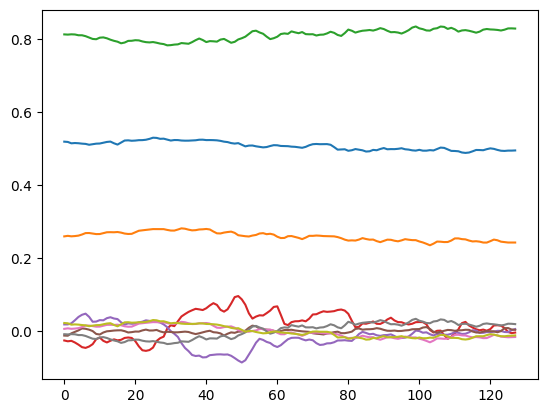

In [21]:
plt.plot(x[19]);

# **Model 🧠**

## RNN

In [57]:
model = nn.RNN(input_size=9, hidden_size=32, num_layers=1,
               nonlinearity='tanh', bias=True, batch_first=True,
               dropout=0.0, bidirectional=False)

In [58]:
model

RNN(9, 32, batch_first=True)

In [59]:
model.all_weights

[[Parameter containing:
  tensor([[ 1.1961e-01,  1.3054e-01,  1.4887e-01,  8.5652e-02, -1.1935e-01,
            1.6800e-01,  1.2297e-01,  9.8801e-03, -6.0172e-02],
          [-1.4234e-01, -1.1388e-01,  7.1711e-02,  2.7057e-02, -1.1226e-01,
            9.8016e-02, -4.9738e-02, -1.5862e-01,  3.9999e-02],
          [-1.2241e-01, -5.2479e-02,  1.6461e-01,  1.3339e-01, -1.2353e-01,
            3.1831e-02,  1.7339e-01,  4.9499e-02, -4.9834e-02],
          [ 1.6799e-01,  6.1412e-02, -7.2906e-02,  3.4188e-03, -9.6688e-02,
            7.0023e-02, -5.8793e-02, -8.4896e-02, -2.8208e-02],
          [ 1.1445e-01,  6.6119e-02, -1.6313e-01, -1.5385e-01, -6.9324e-02,
           -1.6915e-02, -1.2476e-01, -3.1878e-02,  1.0671e-01],
          [-1.1059e-01, -9.8803e-02, -1.7638e-01,  6.2898e-02, -1.2710e-02,
            8.8120e-02, -9.6040e-02,  1.2532e-01,  5.2100e-03],
          [-1.6078e-01,  1.0920e-01, -8.3268e-02,  4.5278e-02,  5.5151e-02,
            6.4678e-02, -1.3296e-01,  9.7291e-02, -2.1454e-0

In [60]:
model.bias_hh_l0, # model.bias_hh_l0_reverse

(Parameter containing:
 tensor([ 0.0705,  0.1041,  0.0434, -0.0467,  0.1763,  0.0695,  0.0232, -0.1752,
         -0.0029, -0.0580,  0.0476, -0.1634,  0.1064, -0.0772,  0.0717,  0.0733,
         -0.0190, -0.1325,  0.1360, -0.1103, -0.1133, -0.1685,  0.0333,  0.1545,
         -0.0255,  0.1345,  0.1695,  0.0218,  0.0315, -0.0842, -0.0895,  0.1037],
        requires_grad=True),)

In [61]:
model.bias_ih_l0, # model.bias_ih_l0_reverse

(Parameter containing:
 tensor([ 0.0560, -0.1627, -0.1067, -0.1746,  0.0140,  0.1589,  0.0850,  0.0389,
         -0.0275, -0.1695, -0.0338, -0.1520, -0.1255, -0.0428,  0.0491, -0.1076,
          0.0328, -0.0091,  0.1700, -0.1231,  0.1234,  0.0884,  0.0617, -0.1509,
          0.0573,  0.1282,  0.0953, -0.1671,  0.0694, -0.1541,  0.0177,  0.0769],
        requires_grad=True),)

In [62]:
model.weight_ih_l0.shape

torch.Size([32, 9])

In [63]:
model.weight_hh_l0.shape

torch.Size([32, 32])

In [64]:
model.parameters()

<generator object Module.parameters at 0x7dd9aa276dc0>

In [69]:
outputs, hidden_state = model(x)

In [70]:
hidden_state.shape

torch.Size([1, 64, 32])

In [71]:
outputs.shape

torch.Size([64, 128, 32])

In [72]:
print(outputs[0, -1])
print(hidden_state[0, 0])

tensor([ 0.1706, -0.1716, -0.1984, -0.2160,  0.1802,  0.2066,  0.2272,  0.0050,
         0.1834, -0.2514, -0.1136, -0.1900,  0.0708, -0.2937,  0.2784,  0.1773,
        -0.0873, -0.1500,  0.2284, -0.3627, -0.1768, -0.1782, -0.0699, -0.1090,
        -0.1406,  0.1120,  0.1314, -0.2160, -0.0130, -0.4691, -0.0166,  0.0098],
       grad_fn=<SelectBackward0>)
tensor([ 0.1706, -0.1716, -0.1984, -0.2160,  0.1802,  0.2066,  0.2272,  0.0050,
         0.1834, -0.2514, -0.1136, -0.1900,  0.0708, -0.2937,  0.2784,  0.1773,
        -0.0873, -0.1500,  0.2284, -0.3627, -0.1768, -0.1782, -0.0699, -0.1090,
        -0.1406,  0.1120,  0.1314, -0.2160, -0.0130, -0.4691, -0.0166,  0.0098],
       grad_fn=<SelectBackward0>)


In [73]:
outputs, hn = model(x, torch.zeros(1, 64, 32))

In [74]:
outputs.shape

torch.Size([64, 128, 32])

In [75]:
model = nn.Sequential(
    nn.RNN(input_size=9, hidden_size=32, num_layers=1,
    nonlinearity='tanh', bias=True, batch_first=True,
    dropout=0.0, bidirectional=False),
    nn.Linear(32, 6)
)

In [76]:
model(x)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not tuple

## Newwwww!

In [ ]:
# Template

# class RNNModel(nn.Module):
#   def __init__(self, ):
#     super().__init__()

#   def forward(self, x):
#     return y

In [22]:
class RNNModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, bidirectional, num_cls):
    super().__init__()
    self.rnn = nn.RNN(input_size=input_size,
                      hidden_size=hidden_size,
                      num_layers=num_layers,
                      bidirectional=bidirectional)

    # hidden_size = hidden_size * 2 if bidirectional else hidden_size
    # self.fc = nn.Linear(hidden_size, num_cls)

    self.fc = nn.LazyLinear(num_cls)

  def forward(self, x):
    outputs, _ = self.rnn(x)
    # y = self.fc(outputs[:, 1]) # out: one
    # outputs = outputs.flatten(1)
    # y = self.fc(outputs)  # out: many
    y = self.fc(outputs[:, -1])
    # y = y.mean(dim=1)
    return y

In [23]:
model = RNNModel(9, 32, 1, True, 6)
model

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


RNNModel(
  (rnn): RNN(9, 32, bidirectional=True)
  (fc): LazyLinear(in_features=0, out_features=6, bias=True)
)

In [24]:
model.rnn.bias_hh_l0.shape

torch.Size([32])

In [27]:
model.fc.bias.shape

torch.Size([6])

In [26]:
model(x).shape

torch.Size([64, 6])

## Params

In [28]:
def num_params(model, k=1e6):
  nums = sum(p.numel() for p in model.parameters())/k
  return nums

In [29]:
num_params(model, 1e3)

3.142

# **Device ⚙️**

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# **Utils 🧰**

In [31]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Functions** 🧮

In [32]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass', num_classes=6).to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [33]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='multiclass', num_classes=6).to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

# **Efficient way for set hyperparams 🔨**

## Step 1: check forward path

Calculate loss for one batch

In [34]:
model = RNNModel(9, 32, 1, False, 6).to(device)
loss_fn = nn.CrossEntropyLoss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(1.7898, device='cuda:0', grad_fn=<NllLossBackward0>)


## Step 2: check backward path

Select 5 random batches and train the model

In [43]:
_, mini_train_dataset = random_split(train_set, (len(train_set)-500, 500))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [44]:
model = RNNModel(9, 32, 1, False, 6).to(device)
loss_fn = nn.CrossEntropyLoss()

In [45]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [46]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 99: 100%|██████████| 25/25 [00:00<00:00, 76.04batch/s, accuracy=82.2, loss=0.472]


## Step 3: select best lr

Train all data for one epoch

In [48]:
num_epochs = 5
for lr in [0.9, 0.1, 0.01]:
  print(f'LR={lr}')
  model = RNNModel(9, 32, 1, False, 6).to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
  print()

LR=0.9


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 102.07batch/s, accuracy=63.3, loss=0.873]



LR=0.1


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 103.38batch/s, accuracy=52.7, loss=1.13]



LR=0.01


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 83.41batch/s, accuracy=40.8, loss=1.56]

## Step 4: small grid (optional)

Create a small grid based on the WD and the best LR



In [49]:
num_epochs = 5

for lr in [0.08, 0.09, 0.1, 0.15, 0.2]:
  for wd in [1e-4, 1e-5, 0.]:
    model = RNNModel(9, 32, 1, False, 6).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    print(f'LR={lr}, WD={wd}')

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    print()

LR=0.08, WD=0.0001


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 109.52batch/s, accuracy=51.8, loss=1.16]



LR=0.08, WD=1e-05


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 80.56batch/s, accuracy=52.9, loss=1.15]



LR=0.08, WD=0.0


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 101.53batch/s, accuracy=52.2, loss=1.17]



LR=0.09, WD=0.0001


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 88.14batch/s, accuracy=52.6, loss=1.14]



LR=0.09, WD=1e-05


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 102.44batch/s, accuracy=53, loss=1.14]



LR=0.09, WD=0.0


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 98.60batch/s, accuracy=52.9, loss=1.14]



LR=0.1, WD=0.0001


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 85.36batch/s, accuracy=52.9, loss=1.13]



LR=0.1, WD=1e-05


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 98.70batch/s, accuracy=53.6, loss=1.12]



LR=0.1, WD=0.0


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 97.11batch/s, accuracy=53.6, loss=1.12]



LR=0.15, WD=0.0001


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 93.26batch/s, accuracy=54.4, loss=1.07]



LR=0.15, WD=1e-05


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 99.05batch/s, accuracy=55.2, loss=1.06]



LR=0.15, WD=0.0


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 91.48batch/s, accuracy=54, loss=1.07]



LR=0.2, WD=0.0001


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 99.36batch/s, accuracy=54.7, loss=1.05]



LR=0.2, WD=1e-05


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 99.93batch/s, accuracy=55.8, loss=1.04]



LR=0.2, WD=0.0


Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 88.21batch/s, accuracy=55.1, loss=1.04]

## Step 5: train more epochs

In [90]:
model = RNNModel(9, 32, 1, False, 6).to(device)

In [91]:
lr = 0.9
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [92]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [93]:
num_epochs = 20

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('model saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 115/115 [00:01<00:00, 104.50batch/s, accuracy=24.3, loss=21.3]


model saved!
Valid: Loss = 51.88, Acc = 0.1822



Epoch 1: 100%|██████████| 115/115 [00:01<00:00, 100.44batch/s, accuracy=20.3, loss=32]


model saved!
Valid: Loss = 38.59, Acc = 0.1815



Epoch 2: 100%|██████████| 115/115 [00:00<00:00, 115.54batch/s, accuracy=17.2, loss=37]


model saved!
Valid: Loss = 31.01, Acc = 0.1805



Epoch 3: 100%|██████████| 115/115 [00:01<00:00, 80.17batch/s, accuracy=17, loss=34.1]


model saved!
Valid: Loss = 20.58, Acc = 0.1788



Epoch 4: 100%|██████████| 115/115 [00:01<00:00, 82.68batch/s, accuracy=17.5, loss=36.6]


Valid: Loss = 34.94, Acc = 0.1805



Epoch 5: 100%|██████████| 115/115 [00:01<00:00, 85.26batch/s, accuracy=16.8, loss=34.8]


Valid: Loss = 27.85, Acc = 0.1598



Epoch 6: 100%|██████████| 115/115 [00:01<00:00, 98.27batch/s, accuracy=17.1, loss=33.4] 


Valid: Loss = 35.3, Acc = 0.1591



Epoch 7: 100%|██████████| 115/115 [00:01<00:00, 88.42batch/s, accuracy=17.1, loss=32.1]


Valid: Loss = 40.99, Acc = 0.1653



Epoch 8: 100%|██████████| 115/115 [00:01<00:00, 81.96batch/s, accuracy=16.9, loss=38.2]


Valid: Loss = 31.45, Acc = 0.1822



Epoch 9: 100%|██████████| 115/115 [00:01<00:00, 79.92batch/s, accuracy=17, loss=31.2]


Valid: Loss = 28.92, Acc = 0.1598



Epoch 10: 100%|██████████| 115/115 [00:01<00:00, 95.15batch/s, accuracy=16.9, loss=33.7] 


Valid: Loss = 60.11, Acc = 0.1425



Epoch 11: 100%|██████████| 115/115 [00:01<00:00, 100.94batch/s, accuracy=17.6, loss=35.1]


Valid: Loss = 25.28, Acc = 0.1663



Epoch 12: 100%|██████████| 115/115 [00:01<00:00, 92.33batch/s, accuracy=17, loss=36.2]


Valid: Loss = 25.68, Acc = 0.1605



Epoch 13: 100%|██████████| 115/115 [00:00<00:00, 119.94batch/s, accuracy=16.7, loss=38.7]


Valid: Loss = 20.74, Acc = 0.1663



Epoch 14: 100%|██████████| 115/115 [00:01<00:00, 101.70batch/s, accuracy=17.2, loss=33.5]


Valid: Loss = 45.01, Acc = 0.1826



Epoch 15: 100%|██████████| 115/115 [00:01<00:00, 101.13batch/s, accuracy=16.9, loss=37.7]


Valid: Loss = 39.88, Acc = 0.1683



Epoch 16: 100%|██████████| 115/115 [00:01<00:00, 94.47batch/s, accuracy=17.2, loss=33.8]


Valid: Loss = 47.57, Acc = 0.1429



Epoch 17: 100%|██████████| 115/115 [00:01<00:00, 96.58batch/s, accuracy=16.2, loss=38.2]


model saved!
Valid: Loss = 20.19, Acc = 0.1429



Epoch 18: 100%|██████████| 115/115 [00:01<00:00, 90.99batch/s, accuracy=17.3, loss=35.9]


model saved!
Valid: Loss = 14.25, Acc = 0.1829



Epoch 19: 100%|██████████| 115/115 [00:01<00:00, 85.30batch/s, accuracy=16.3, loss=39.9]


Valid: Loss = 64.25, Acc = 0.1683



# **Plot**

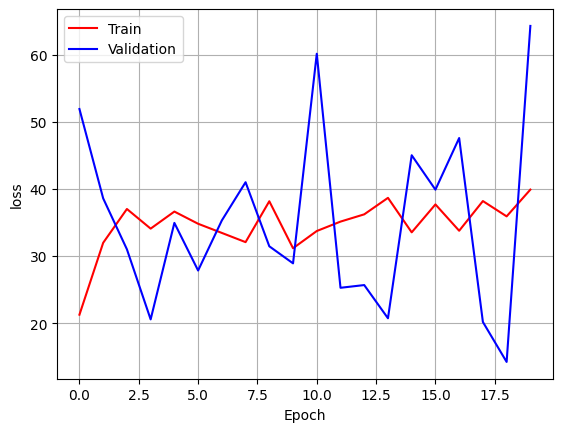

In [94]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

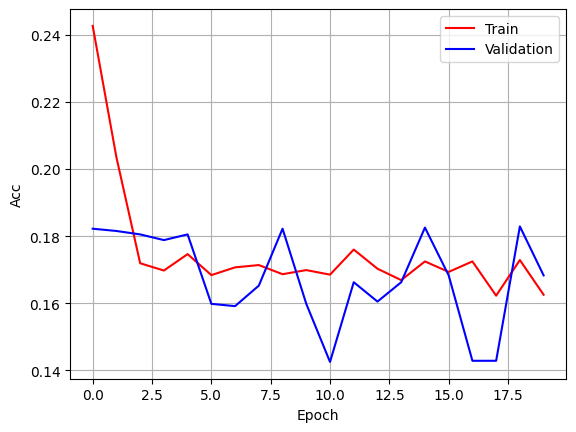

In [95]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()